---
title: Broadcasting
---

## What is Broadcasting?

In PyTorch, broadcasting refers to the automatic expansion of a tensor's dimensions to match the dimensions of another tensor during an operation. This allows for element-wise operations between tensors of different shapes, as long as certain rules are followed.

For example, consider the following operation:

In [2]:
import torch

a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
c = a + b
c

tensor([5, 7, 9])

Here, `a` and `b` are both 1-dimensional tensors with shape `(3,)`. When performing the addition operation, PyTorch will "broadcast" a to have the same shape as b, resulting in a tensor c with shape `(3,)` and values `[5, 7, 9]`.

Broadcasting can also occur when one tensor has fewer dimensions than the other. For example:

In [2]:
a = torch.tensor([[1, 2, 3],
                  [4, 5, 6]])
b = torch.tensor([7, 8, 9])
c = a + b

Here, `a` has shape `(2, 3)` and `b` has shape `(3,)`. To perform the addition, PyTorch will broadcast b to have shape `(1, 3)`, resulting in a tensor c with shape `(2, 3)` and values.

In [3]:
c

tensor([[ 8, 10, 12],
        [11, 13, 15]])

Broadcasting is a powerful feature in PyTorch that allows for efficient operations between tensors of different shapes and is an important concept to understand when working with deep learning models.

## General Broadcasting rules

The rules for broadcasting in PyTorch are the same as those in [NumPy](https://numpy.org/doc/stable/user/basics.broadcasting.html).

When comparing two arrays, PyTorch compares their shapes element-wise. It starts with the rightmost dimension and works its way left. Two dimensions are "broadcastable" when - 

1. they are equal, or
2. one of them is 1

If these conditions are not met, a `RuntimeError` occurs, explaining the size of tensors is incompatible. 

When performing a broadcast operation, the resulting array will have the same number of dimensions as the input array with the most dimensions. The size of each dimension in the resulting array will be the maximum size of the corresponding dimension among the input arrays. If an input array is missing a dimension, it is assumed to have a size of one in that dimension.


Let's look at some broadcasting examples.

### Example 1 : Valid broadcasting

In [21]:
tensor_a = torch.tensor([[1,2],[3,4],[5,6]])
tensor_b = torch.tensor([[7,8]])
print(f"Shape of tensor a is {tensor_a.shape}")
print(f"Shape of tensor b is {tensor_b.shape}")

Shape of tensor a is torch.Size([3, 2])
Shape of tensor b is torch.Size([1, 2])


In the example above, tensor_a is of shape `(3,2)` and tensor_b is of shape `(1,2)`. According to broadcasting principle if we start from the rightmost side - 

- Rightmost dimension is 2 for both tensor_a and tensor_b
- Second rightmost dimension is 3 for tensor_a and 1 for tensor_b, as one of them is 1, it doesn't violate the broadcasting rules


In [22]:
tensor_c = tensor_a + tensor_b
print(f"Shape of tensor c is {tensor_c.shape}")

Shape of tensor c is torch.Size([3, 2])


Since all the broadcasting rules are valid, the resultant sum of the tensors is `(3,2)` where tensor_b is expanded from size `(1,2)` to `(3,2)` and then added element wise with tensor_a.

### Example 2 : Invalid Broadcasting

In [23]:
tensor_a = torch.tensor([[1,2],[3,4],[5,6]])
tensor_b = torch.tensor([[7,8,9]])
print(f"Shape of tensor a is {tensor_a.shape}")
print(f"Shape of tensor b is {tensor_b.shape}")

Shape of tensor a is torch.Size([3, 2])
Shape of tensor b is torch.Size([1, 3])


In the example above, tensor_a is of shape `(3,2)` and tensor_b is of shape `(1,3)`. According to broadcasting principle if we start from the rightmost side - 

- Rightmost dimension is 2 for tensor_a and 3 for tensor_b, there is a mismatch
- Second rightmost dimension is 3 for tensor_a and 1 for tensor_b, as one of them is 1, it doesn't violate the broadcasting rules

In [24]:
tensor_c = tensor_a + tensor_b

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1

Since all the broadcasting rules are not valid, the resultant sum leads to a run time error explaining that the rightmost dimension of the tensors is not matching.

## Exercise: K Means using Broadcasting principle

In this section, we will be using broadcasting principles to showcase the power of broadcasting and implement our version of K-means clustering which can run on PyTorch. K-Means is a clustering algorithm that is used to group a set of data points into a specified number of clusters. Here is the general pseudocode for the K-Means algorithm:

- Initialize the number of clusters, `k`, and the maximum number of iterations, `max_iter`.
- Randomly select `k` data points as the initial centroids for the clusters.
- Iterate for a maximum of `max_iter` times:
    - Assign each data point to the cluster with the nearest centroid.
    - Calculate the new centroid for each cluster by taking the mean of all data points in the cluster.
- Return the final clusters and their centroids.

### Create some random data

Let's try to create some random data using scikit-learn `make_blobs` function.

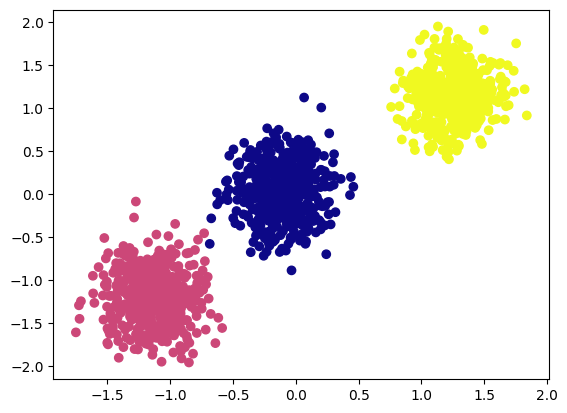

In [3]:
#| fig-cap: Fig 3.1. Visualizing randomly created clusters. 
#| fig-align: left
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

n_samples = 1500
X, y = make_blobs(n_samples=n_samples, centers = 3, random_state=3)

## Normalize
X = (X - X.mean(axis=0))/X.std(axis=0)
X = torch.from_numpy(X)
def plot_cluster(data, y, points=[]):
    fig, ax = plt.subplots()
    ax.scatter(data[:,0], data[:,1], c=y, cmap='plasma')
    for i, point in enumerate(points):
        ax.plot(*point, markersize=10, marker="x", color='r', mew=5)
        ax.plot(*point, markersize=5, marker="x", color='b', mew=2)

plot_cluster(X, y)

As we can see above, we have created 1500 samples with three clusters.

### Randomly initialize the centroids

For this exercise, we will use a random initialization for the centroids, although there are more sophisticated techniques such as the "kmeans++" method that can be used to improve the convergence of the algorithm. For the sake of simplicity, we will stick with random initialization.

In [5]:
torch.manual_seed(2)
centroids = torch.randn((3,X.shape[1]))
print(f"Shape: {centroids.shape} \n {centroids}")

Shape: torch.Size([3, 2]) 
 tensor([[ 0.3923, -0.2236],
        [-0.3195, -1.2050],
        [ 1.0445, -0.6332]])


Let's visualize the randomly initialized centroids.

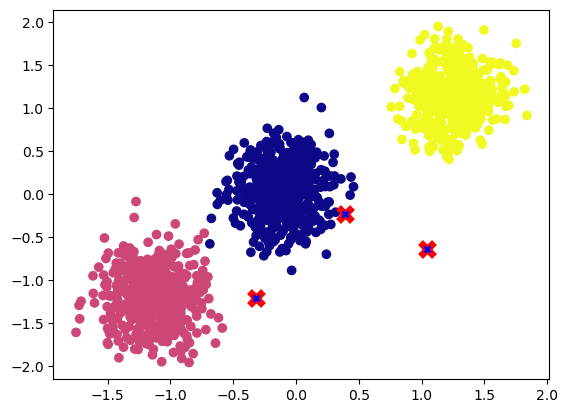

In [6]:
#| fig-cap: Fig 3.2. Visualizing randomly created centroid and cluster. 
#| fig-align: left
plot_cluster(X, y, centroids)

As we can see in the visualization above, the centroids are random.

### Assign cluster to the nearest centroid

We have 1500 samples and three randomly initialized centroids. Now to compute the distance between these centroids and samples we can make use of broadcasting which is vectorized and significantly improve our compute times as we don't need to loop each sample and centroid to calculate distance. 

To do broadcasting, we need to make sure that the two tensors are compatible for broadcasting, to achieve this we will add an additional dimension using `unsqueeze` method.

In [7]:
print(f"Before unsqueeze: \n Data shape: {X.shape}, Centroid shape: {centroids.shape}")
print(f"\nAfter unsqueeae: \n Data shape: {X.unsqueeze(1).shape}, Centroid shape: {centroids.unsqueeze(0).shape}")

Before unsqueeze: 
 Data shape: torch.Size([1500, 2]), Centroid shape: torch.Size([3, 2])

After unsqueeae: 
 Data shape: torch.Size([1500, 1, 2]), Centroid shape: torch.Size([1, 3, 2])


We can now compute the Euclidean distance between all 1500 samples and the three centroids in a vectorized format. To do this, we will subtract each centroid from the samples, square the differences, and sum them.

In [8]:
square_dist = (X.unsqueeze(1) - centroids.unsqueeze(0)).square().sum(axis=-1)
print(f"Distance of 1500 samples with three centroids : {square_dist.shape}")

Distance of 1500 samples with three centroids : torch.Size([1500, 3])


For assigning a sample to the nearest cluster we can use the `argmin` function to find the cluster with the smallest distance for each sample.

In [9]:
print(pd.DataFrame(square_dist.argmin(-1)).value_counts())

0    974
1    515
2     11
dtype: int64


We can see that 974 samples are close to centroid 0 and 515 samples are near centroid 1 and 11 samples are close to sample 2. Now let's pack all of the above in a simple function.

In [10]:
def nearest_centroid(data, points):
    '''
    Find nearest centroid for each sample 
    '''
    return (data.unsqueeze(1) - points.unsqueeze(0)).square().sum(axis=-1).argmin(-1)

## Check if it works as before
nc = nearest_centroid(X,centroids)
print(pd.DataFrame(nc).value_counts())

0    974
1    515
2     11
dtype: int64


Let's visualize the cluster assignment.

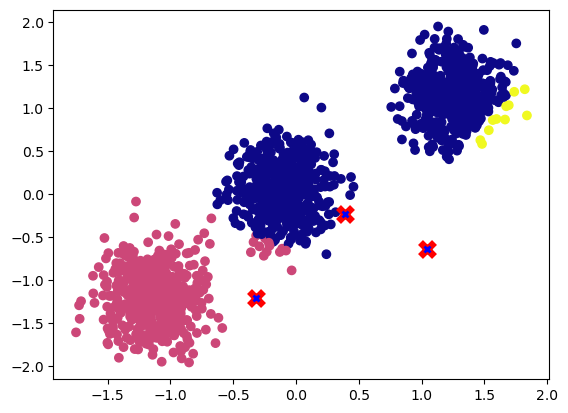

In [11]:
#| fig-cap: Fig 3.3. Visualizing newly created cluster based on centroids
#| fig-align: left
plot_cluster(X, nc, centroids)

### Update centroids based on new clusters

To obtain the new centroid coordinates, we need to compute the mean of all the samples that are assigned to the cluster and update the centroids accordingly.

In [12]:
def update_centroids(data, nc):
    return  torch.cat([data[nc == val,:].mean(axis=0, keepdim=True) for val in torch.unique(nc)], 0)
new_centroids = update_centroids(X, nc)

Lets visualize the new updated centroids.

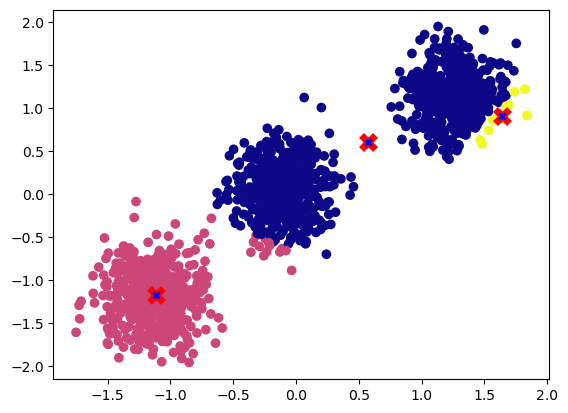

In [13]:
#| fig-cap: Fig 3.4. Visualizing newly created centroids based on nearest cluster assignment
#| fig-align: left
plot_cluster(X, nc, new_centroids)

We can see updated centroids moved to the middle of the cluster.

### Iterate for a maximum of max_iter times

Let's set max_iter to 20 and run the cluster assignment and update the centroids for max_iter times.

In [14]:
max_iter = 20
torch.manual_seed(2)
centroids = torch.randn((3,X.shape[1]))
for _ in range(max_iter):
    nc = nearest_centroid(X,centroids)
    centroids = update_centroids(X, nc)

Let's visualize the centroids after running it `max_iter` times.

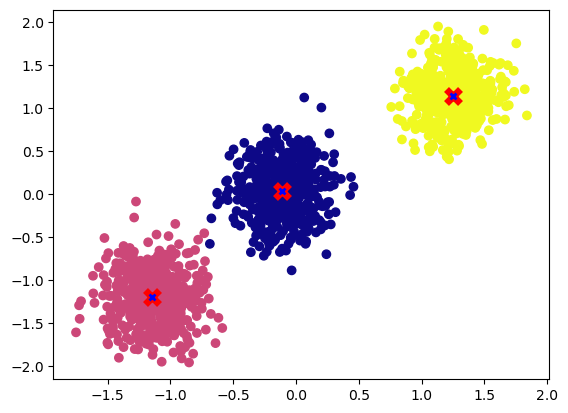

In [15]:
#| fig-cap: Fig 3.5. Visualizing final cluster centers with original labels
#| fig-align: left
plot_cluster(X, y, centroids)

We can see now that the centroids have converged to the desired cluster center.

### Packaging all up

Let's package all the above functions to do K means.

In [46]:
def nearest_centroid(data, points):
    return (data.unsqueeze(1) - points.unsqueeze(0)).square().sum(axis=-1).argmin(-1)

def update_centroids(data, nc):
    return  torch.cat([data[nc == val,:].mean(axis=0, keepdim=True) for val in torch.unique(nc)], 0)

def k_means(X, k, max_iter=20, device="cpu"):
    ## Random initialization
    if device == "cpu": 
        X = X.detach().cpu()
    else: 
        X = X.to(device)
    
    centroids = torch.randn((k,X.shape[1])).to(device)
    
    ## Updating centroids for max_iter
    for iter in range(max_iter): 
        new_centroids = update_centroids(X, nearest_centroid(X,centroids)).to(centroids.dtype)
        
        ## Early stopping
        if torch.equal(centroids,new_centroids): break
        else: centroids = new_centroids
            
    return centroids

Let's check if the function runs correctly.

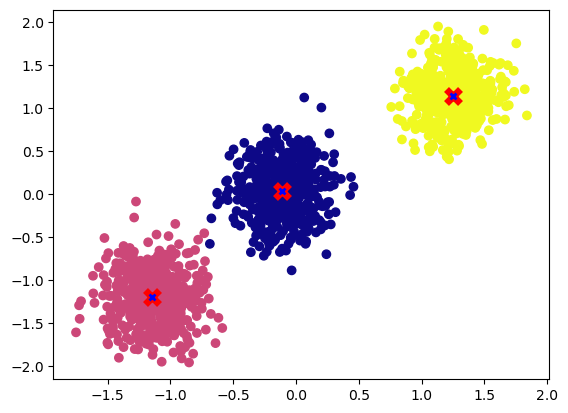

In [55]:
#| fig-cap: Fig 3.6. Visualizing output cluster centers with original labels
#| fig-align: left
centroids = k_means(X,3)
plot_cluster(X, y, centroids)

Let's run the function on GPU.

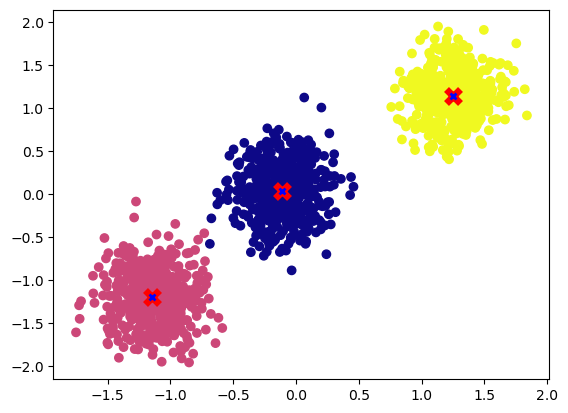

In [54]:
#| fig-cap: Fig 3.7. Visualizing output cluster centers with original labels
#| fig-align: left
centroids = k_means(X,3, device="cuda").detach().cpu()
plot_cluster(X.detach().cpu(), y, centroids)

## Conclusion

Broadcasting is a powerful feature in PyTorch that allows you to perform arithmetic operations on tensors of different shapes, as long as they are "broadcastable." 

As we have seen above, broadcasting allows you to perform operations on tensors of different shapes as if they were the same shape, by repeating or "broadcasting" the values of the smaller tensor along the missing dimensions. This can be a useful way to perform element-wise operations on tensors without having to explicitly pad or resize them.